# Imports

In [6]:
%matplotlib inline

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Global variables

In [7]:
train_ = False
load_ = True

label_name = ["palm_horizontal", "L", "fist_horizontal", "fist_vertical", "thumb_up", "index", "ok", "palm_vertical", "C", "thumb_down"]
test_size = 0.25
img_width = 120
img_height = 120

# Loading and pre processing data

In [8]:
def load_data(width, height, oper_sys):
    X = []
    y = []
    stop = False
    if oper_sys == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, dirs, files in tqdm(os.walk(".", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("png"):
                # Loading labels
                category = path.split(split_)[4]
                label = int(category.split("_")[0]) - 1
                y.append(label)
                # Loading images
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (width, height))
                X.append(img)
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], height, width, 1), y

3it [00:00, 1660.45it/s]

(0, 120, 120, 1)
(0,)


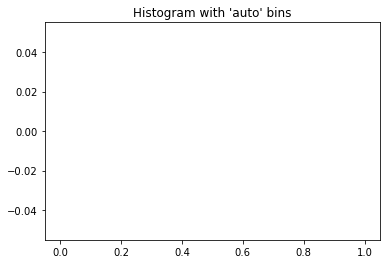

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [9]:
if load_ : 
    X, y = load_data(width=img_width, height=img_height, oper_sys="windows")
    print(X.shape)
    print(y.shape)
    plt.hist(y, bins=10, width=0.7)
    plt.title("Histogram with 'auto' bins")
    plt.show()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [ ]:
# Decomment to check if the images are correctly labeled
# for i in range(X.shape[0]):
#     if i % 500 == 0:
#         plt.imshow(X[i])
#         plt.show()
#         print(label_name[y[i]])

# Building and training simple model

In [ ]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(img_width, img_height, 1))) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(label_name), activation='softmax'))
    return model

In [ ]:
if train_ :
    model = build_model()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))
    model.save('tmp_model.h5')
else:
    model = tf.keras.models.load_model("model.h5", custom_objects=None, compile=True, options=None)

model.summary()
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

# Using model in inference with computer webcam

In [ ]:
plt.imshow(X[5000])

In [ ]:
inference_ = True

if inference_ :
    cv2.destroyAllWindows()

    before = time.time()
    vid = cv2.VideoCapture(0)
    while True:
        ret, frame = vid.read()
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # after = int(time.time() - before)
        # if after % 5 == 0:
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img_width, img_height))
        img = img.reshape(1, img_width, img_height, 1)
        print(label_name[np.argmax(model.predict(img))])

    vid.release()
    cv2.destroyAllWindows()

In [ ]:
# For our problem we should take the best prediction out of 100 images, for each final prediction (less error and less decision taken so the robot doesnt go left right left right etc..)